In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
device='cuda' if torch.cuda.is_available() else 'cpu'

import torch.nn as nn
from torch.utils.data import TensorDataset,DataLoader
from torch.optim import lr_scheduler #学习率衰减
from pytorch_pretrained_bert import BertModel, BertTokenizer, BertForSequenceClassification

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from sklearn.model_selection import StratifiedKFold

In [26]:
batch_size=32
epochs = 15  # 训练数据集的轮次
lr_rate=1e-3
weight_decay = 1e-3
lr_patience = 1 # 1 model not improving until lr is decreasing
lr_factor = 0.1 # by how much the lr is decreasing

In [3]:
data = pd.read_excel('D:/tdb/shili/data2.xlsx')
data.head()

,留言编号,留言用户,留言主题,留言时间,留言详情,一级分类
0,24,A00074011,A市西湖建筑集团占道施工有安全隐患,2020/1/6 12:09:38,\n\t\t\t\t\t\n\t\t\t\t\tA3区大道西行便道，未管所路口至加油站路段，...,城乡建设
1,37,A000107866,A市在水一方大厦人为烂尾多年，安全隐患严重,2020/1/4 11:17:46,\n\t\t\t\t\t\n\t\t\t\t\t位于书院路主干道的在水一方大厦一楼至四楼人为...,城乡建设
2,3742,A00013884,A3区杜鹃文苑小区外的非法汽车检测站要开业了！,2018/12/26 10:13:37,\n\t\t\t\t\t\n\t\t\t\t\tA市政府、市交警支队、市安监局、市环保局、A...,城乡建设
3,5315,A0009647,民工在A6区明发国际工地受伤，工地方拒绝支付医疗费,2018/7/17 7:13:58,\n\t\t\t\t\t\n\t\t\t\t\t胡书记，您好，感谢您百忙之中查看这份留言。我...,城乡建设
4,100026,A00047862,K8县丁字街的商户乱摆摊,2017/10/14 14:25:14,\n\t\t\t\t\t\n\t\t\t\t\t K8县丁字街的商户乱摆摊，前段时间丁字街...,城乡建设


In [4]:
num_labels = len(data['一级分类'].value_counts())
data['一级分类'].value_counts()

劳动和社会保障    104
城乡建设       101
教育文体        96
卫生计生        58
交通运输        55
商贸旅游        48
环境保护        33
Name: 一级分类, dtype: int64

In [5]:
UNCASED='D:/ipython/Lib/site-packages/pytorch_pretrained_bert/cache/'
# 加载bert的分词器
tokenizer = BertTokenizer.from_pretrained(os.path.join(UNCASED,'bert-base-chinese-vocab.txt'))

In [8]:
MAX_LEN = 32

lbe = LabelEncoder()
labels = np.array(lbe.fit_transform(data['一级分类']))
#分字
tokens = np.array([tokenizer.tokenize(sentence)[:MAX_LEN] for sentence in data['留言主题']])
print(tokens[0])
#编码
input_ids = np.array([tokenizer.convert_tokens_to_ids(t + ['[PAD]'] * (MAX_LEN-len(t))) for t in tokens])
print(input_ids[0])

['a', '市', '西', '湖', '建', '筑', '集', '团', '占', '道', '施', '工', '有', '安', '全', '隐', '患']
[ 143 2356 6205 3959 2456 5029 7415 1730 1304 6887 3177 2339 3300 2128
 1059 7391 2642    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [9]:
# 划分训练集和测试集
train_inputs,test_inputs,train_labels,test_labels = train_test_split(input_ids,labels,test_size=0.2,random_state=123, stratify=labels)

train_inputs=torch.from_numpy(train_inputs).long()
test_inputs=torch.from_numpy(test_inputs).long()
train_labels=torch.from_numpy(train_labels).long()
test_labels=torch.from_numpy(test_labels).long()
print(train_inputs.size(),train_labels.size(),test_inputs.size(),test_labels.size())

train_data = TensorDataset(train_inputs,train_labels)
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)

valid_data = TensorDataset(test_inputs,test_labels)
valid_loader = DataLoader(valid_data,batch_size=batch_size,shuffle=False)

torch.Size([396, 32]) torch.Size([396]) torch.Size([99, 32]) torch.Size([99])


In [34]:
textCNN_param = {
    'vocab_size': 10000,
    'embed_dim': 768,
    'class_num': num_labels,
    "kernel_num": 16,
    "kernel_size": [2, 3, 4],
    "dropout": 0.2,
}

class TextCNN(nn.Module):
    def __init__(self,textCNN_param):
        super(TextCNN,self).__init__()
        vocab_size = textCNN_param['vocab_size']
        embed_dim =  textCNN_param['embed_dim']
        class_num =  textCNN_param['class_num']
        kernel_num =  textCNN_param['kernel_num']
        kernel_size =  textCNN_param['kernel_size']
        dropout_rate =  textCNN_param['dropout']
        
        #self.embed = nn.Embedding(vocab_size,embed_dim,padding_idx=0)
        self.conv1 = nn.Conv2d(1,kernel_num,(kernel_size[0],embed_dim))
        self.conv2 = nn.Conv2d(1,kernel_num,(kernel_size[1],embed_dim))
        self.conv3 = nn.Conv2d(1,kernel_num,(kernel_size[2],embed_dim))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(len(kernel_size)*kernel_num, class_num)
    
#     def init_embed(self,pretrain_embed):
#         self.embed.weight = nn.Parameter(torch.Tensor(pretrain_embed))
    
    @staticmethod
    def conv_and_pool(x, conv):
        x = conv(x).squeeze(3)
        x = torch.relu(x)
        x = torch.max_pool1d(x, x.size(2)).squeeze(2)
        #  (batch, kernel_num)
        return x

    def forward(self,x):
        # 分词，word2id，统一序列长度（长的截断，短的填充0）
        #x=self.embed(x).unsqueeze(1) # x: (batch, 1, sentence_length, embed_dim)
        
        x1 = self.conv_and_pool(x,self.conv1)
        x2 = self.conv_and_pool(x,self.conv2)
        x3 = self.conv_and_pool(x,self.conv3)
        
        x = torch.cat((x1,x2,x3),dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x
    
    # 权重初始化
    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                m.bias.data.zero_()

In [28]:
def train(train_loader):
    # 模型训练
    model.train()
    
    train_loss =0.0
    total=0
    train_correct=0
    for batch_idx,(inputs,label) in enumerate(train_loader):
        # 部署到device
        inputs,label = inputs.to(device), label.to(device)
        text_embed=embed_model(inputs).unsqueeze(1) # 取字向量的embedding表示
        optimizer.zero_grad()
        outputs = model(text_embed)
        loss = criterion(outputs,label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        _,pred=torch.max(outputs,dim=1)
        # Compute accuracy
        train_acc = (label==pred).sum().item()
        total += label.size(0)
        train_correct += train_acc
        
        if batch_idx%5==4:
            print('[%d,%5d] loss:%.3f' % (epoch+1,batch_idx+1,train_loss/(batch_idx+1)))
    
    train_correct = train_correct/total
    train_loss = train_loss/(batch_idx+1)
    print('acc: %.3f' % train_correct)
    
    # Clear memory
    del inputs, label
    return train_loss,train_correct

def valid(valid_loader,valid_labels):
    # 模型验证
    model.eval()
    
    valid_loss =0.0
    correct = 0
    total = 0
    valid_pred = torch.zeros(len(valid_labels), device=device, dtype=torch.float32)
    with torch.no_grad():
        for batch_idx,(inputs,label) in enumerate(valid_loader):
            inputs,label = inputs.to(device), label.to(device)
            text_embed=embed_model(inputs).unsqueeze(1)
            outputs = model(text_embed)
            loss = criterion(outputs,label)
            valid_loss += loss.item()
            
            _,pred=torch.max(outputs,dim=1)
            # Compute accuracy
            valid_acc = (label==pred).sum().item()
            total += label.size(0)
            correct += valid_acc
            valid_pred[batch_idx*batch_size:total] = pred
    
    correct = correct/total
    valid_loss = valid_loss/(batch_idx+1)
    fscore = f1_score(valid_labels, valid_pred,average='macro')
    print('Accuracy on valid set: %d %% ' % (100*correct),'| f1-score:{0:.1f}%'.format(fscore*100))
    
    # Clear memory
    del inputs, label
    return valid_loss,round(fscore,3)

begin to train!
[1,    5] loss:1.991
[1,   10] loss:1.879
acc: 0.260


D:\ipython\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy on valid set: 45 %  | f1-score:27.9%
[2,    5] loss:1.271
[2,   10] loss:1.284
acc: 0.591
Accuracy on valid set: 58 %  | f1-score:48.0%
[3,    5] loss:0.887
[3,   10] loss:0.858
acc: 0.795
Accuracy on valid set: 65 %  | f1-score:63.2%
[4,    5] loss:0.613
[4,   10] loss:0.566
acc: 0.904
Accuracy on valid set: 68 %  | f1-score:66.3%
[5,    5] loss:0.396
[5,   10] loss:0.406
acc: 0.934
Accuracy on valid set: 70 %  | f1-score:70.1%
[6,    5] loss:0.277
[6,   10] loss:0.263
acc: 0.995
Accuracy on valid set: 72 %  | f1-score:71.6%
[7,    5] loss:0.173
[7,   10] loss:0.216
acc: 0.970
Accuracy on valid set: 71 %  | f1-score:70.1%
[8,    5] loss:0.151
[8,   10] loss:0.152
acc: 0.987
Accuracy on valid set: 70 %  | f1-score:69.4%
Epoch     8: reducing learning rate of group 0 to 1.0000e-04.
[9,    5] loss:0.140
[9,   10] loss:0.127
acc: 0.987
Accuracy on valid set: 71 %  | f1-score:70.1%
[10,    5] loss:0.117
[10,   10] loss:0.126
acc: 0.992
Accuracy on valid set: 70 %  | f1-score:69.4%

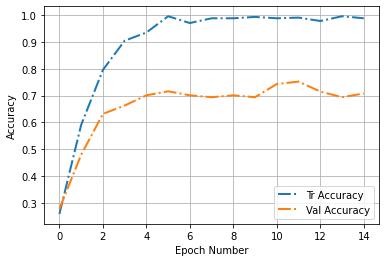

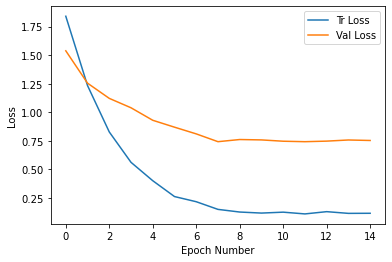

In [35]:
# 取模型中的embedding层
model0 = BertModel.from_pretrained(UNCASED)
embed_model = nn.Sequential(list(model0.children())[0])

model = TextCNN(textCNN_param)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(),lr=lr_rate,betas=(0.9, 0.999),eps = 1e-8,weight_decay=weight_decay)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='max', 
                                patience=lr_patience, verbose=True, factor=lr_factor)

if __name__== '__main__':
    #训练
    print('begin to train!')

    best_correct = 0
    count=0 #当正确率超过6次没有提升，break
    history=[]
    #训练
    for epoch in range(epochs):
        train_loss,train_correct=train(train_loader)
        valid_loss,valid_correct=valid(valid_loader,test_labels)
        scheduler.step(valid_correct)
        history.append([train_loss,valid_loss,train_correct,valid_correct])

        if valid_correct>best_correct:
            best_correct=valid_correct
            count=0
        else:
            count+=1

        if count==6:
            break
    #torch.cuda.empty_cache() #清除gpu缓存
    
    history=np.array(history)
    
    #保存网络参数
    plt.plot(history[:,2:4], ls="-.", lw=2)
    plt.legend(['Tr Accuracy', 'Val Accuracy'])
    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy')
    plt.grid()#网格
    plt.show()
    #梯度下降曲线
    plt.plot(history[:,0:2])
    plt.legend(['Tr Loss', 'Val Loss'])
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss')
    plt.show()